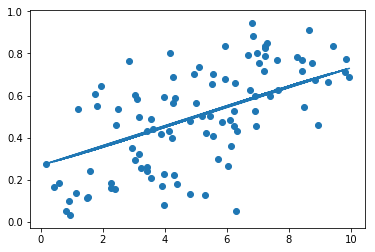

In [13]:
"""
# Header ------------------------------------------------------------------

Fitting a beta linear regression in JAGS

# In this code we generate some data from a beta linear regression model and fit is using jags. We then intepret the output.

"""
import pyjags
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tools.plotting import *

"""
# Maths -------------------------------------------------------------------

# Description of the Bayesian model fitted in this file
# Notation:
# y_t = repsonse variable for observation t=1,..,N - should be in the range (0, 1)
# x_t = explanatory variable for obs t
# alpha, beta = intercept and slope parameters to be estimated
# sigma = residual standard deviation

# Likelihood:
# y_t ~ Beta(a[t], b[t])
# mu[t] = a[t]/(a[t] + b[t])
# a[t] = mu[t] * phi
# b[t] = (1 - mu[t]) * phi
# logit(mu[t]) = alpha + beta * x[t]
# Prior
# alpha ~ N(0,100) - vague priors
# beta ~ N(0,100)
# phi ~ U(0, 100)

"""

# Simulate data ----------------------------------------------------------

np.random.seed(123)
np.set_printoptions(precision=1) # Number of digits of precision for floating point output

T = 100
alpha = -1
beta = 0.2
phi = 5

x = np.random.uniform(0,10,T) 
logit_mu = alpha + beta * x
mu =  np.exp(logit_mu)/(1+np.exp(logit_mu)) # inverse logit
a = mu * phi
b = (1 - mu) * phi
y = np.random.beta(a,b,T)

# Create a plot:
plt.scatter(x, y)
plt.plot(x, mu)

In [14]:
# Jags code ---------------------------------------------------------------

# Jags code to fit the model to the simulated data

code = '''
model
{
  # Likelihood
  for (t in 1:T) {
  y[t] ~ dbeta(a[t], b[t])
  a[t] <- mu[t] * phi
  b[t] <- (1 - mu[t]) * phi
  logit(mu[t]) <- alpha + beta * x[t]
  }
  
  # Priors
  alpha ~ dnorm(0, 10^-2)
  beta ~ dnorm(0, 10^-2)
  phi ~ dunif(0, 10)
}
'''

In [16]:
# Set up the data:
model = pyjags.Model(code, data=dict(T = T, y = y, x = x), chains=4) # Chains = Number of different starting positions


# Choose the parameters to watch and iterations:
samples = model.sample(1000, vars=['alpha', 'beta', 'phi'])

"""
Simulated results ----------------------------------------------------------------
"""
def summary(samples, varname, p=95):
    values = samples[varname]
    ci = np.percentile(values, [100-p, p])
    print('{:<6} mean = {:>5.1f}, {}% credible interval [{:>4.1f} {:>4.1f}]'.format(
      varname, np.mean(values), p, *ci))

for varname in ['alpha', 'beta', 'phi']:
    summary(samples, varname)



adapting: iterations 4000 of 4000, elapsed 0:00:03, remaining 0:00:00
sampling: iterations 4000 of 4000, elapsed 0:00:03, remaining 0:00:00
alpha  mean =  -1.3, 95% credible interval [-1.6 -1.1]
beta   mean =   0.3, 95% credible interval [ 0.2  0.3]
phi    mean =   5.9, 95% credible interval [ 4.6  7.2]


/Users/alaninglis/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/alaninglis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.


Mean:
Variable
alpha   -1.332626
beta     0.256478
phi      5.888859
dtype: float64
Credible Intervals:
Variable     alpha      beta       phi
0.05     -1.628537  0.206247  4.630623
0.95     -1.051379  0.309350  7.232485


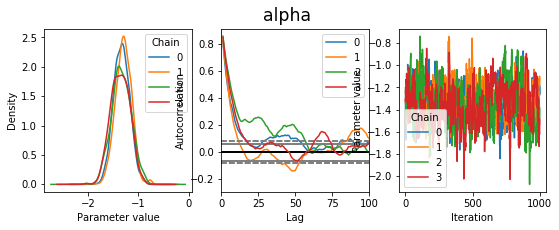

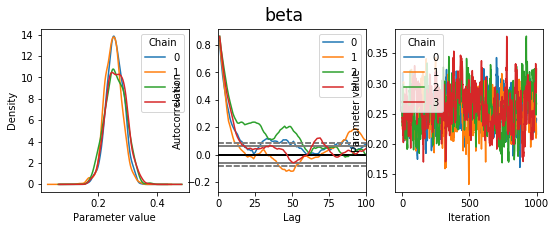

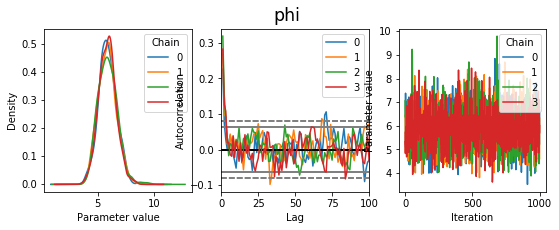

In [18]:
# Use pandas three dimensional Panel to represent the trace:
trace = pd.Panel({k: v.squeeze(0) for k, v in samples.items()})
trace.axes[0].name = 'Variable'
trace.axes[1].name = 'Iteration'
trace.axes[2].name = 'Chain'
 
# Point estimates:
print("Mean:")
print(trace.to_frame().mean())
 

# Bayesian equal-tailed 95% credible intervals:
print("Credible Intervals:")
print(trace.to_frame().quantile([0.05, 0.95]))
 

def plot(trace, var):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    fig.suptitle(var, fontsize='xx-large')
 
    # Marginal posterior density estimate:
    trace[var].plot.density(ax=axes[0])
    axes[0].set_xlabel('Parameter value')
    axes[0].locator_params(tight=True)
 
    # Autocorrelation for each chain:
    axes[1].set_xlim(0, 100)
    for chain in trace[var].columns:
        autocorrelation_plot(trace[var,:,chain], axes[1], label=chain)
 
    # Trace plot:
    axes[2].set_ylabel('Parameter value')
    trace[var].plot(ax=axes[2])
 
   
 # Display diagnostic plots
for var in trace:
    plot(trace, var)
 

# Create a plot of the posterior mean regression line

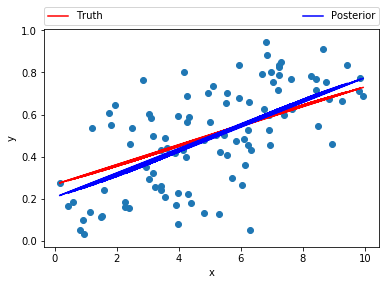

In [22]:
alpha_mean = -1.332626
beta_mean = 0.256478

# Creating a plot:
plt.scatter(x,y)
plt.ylabel('y')
plt.xlabel('x')
plt.plot(x,np.exp(alpha + beta * x)/(1+np.exp(alpha + beta * x)), c= "red", label = "Truth")
plt.plot(x, np.exp(alpha_mean + beta_mean * x)/(1+np.exp(alpha_mean + beta_mean * x)), c = "blue",label = "Posterior")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

Blue and red lines should be pretty close